# Desarrollo y comparación de modelos de aprendizaje automático para la predicción del ciclo de vida útil restante (RUL) en motores turbofán: integración de Graph Neural Networks (GNN) y XGBoost

**Integrantes: Jose Manuel López Arias, Sara Illatopa Marín, David Alvarez Grisales, Julio Cesar Posada**

**Materias Integradoras:**

*   Aprendizaje Automático
*   Almacenamiento y Procesamiento de Grandes Volúmenes de Datos
*   Visualización de datos





**Abstract**

El siguiente proyecto implementa y realiza la comparación de dos enfoques o modelos de aprendizaje automático para la predicción del ciclo de vida restante útil ("RUL" por sus siglas en inglés) de motores turbofán utilizando el dataset NASA C-MAPPS (subset FD001). Se desarrollaron modelos basados en XGBoost y Graph Neural Networks (GNN), integrando un autoencoder para la reducción del ruido y un análisis de importancia de características mediante XGBoost y Lasso. Los experimentos muestran qué la arquitectura de las GNN (Redes neuronales gráficas) captura de una manera más efectiva la dinámica temporal de la degradación del motor, alcanzando un RMSE significativamente  menor respecto al modelo tradicional de XGBoost. Los resultados confirman la hipótesis del potencial de las Redes Neuronales Gráficas como método efectivo de aplicación al mantenimiento predictivo.

**Objetivo**

Desarrollar, optimizar y comparar modelos predictivos (tradicional machine learning vs arquitectura moderna basada en grafos con deep learning) para estimar el ciclo de vida restante útil de motores turbofán, con el fin de identificar el modelo más adecuado para aplicaciones de mantenimiento predictivo más específicamente la degradación de un motor turbofán en el tiempo medido en ciclos.

**Índice**

   Abstract

   Objetivo del proyecto

1.   Carga de datos e importaciones de librerías

2. Análisis Exploratorio de Datos (EDA)

2.1. RUL de Train y Test

2.2. Mapa de correlación

2.3. Motores 1 y 5 vs sensores

3. Refinamiento del conjunto de sensores

4. Normalización (GNN: MinMax) (XGB: StandardScaler)

5. Implementación de XGBoost sin Embeddings

6. Implementación de XGBoost con Embedings

7. Implementación de Graph Neural Networks

8. Implementación de XGBOOST + LASSO para la optimización

9. Ajuste de hiperparámetros

9.1. Ajuste de hiperparámetros XGB

9.2. Ajuste de hiperparámetros para GNN

10. Implementación de XGBoost con ajuste hiperparámetros

10.2. Implementación de GNN con ajuste hiperparámetros

11. Tabla comparativa Global

12. Visualizaciones comparativas finales

13. Conclusiones

**1. Carga de datos e importaciones de librerías**

En esta primera sección se importan las librerías necesarias para el procesamiento, visualización y modelado del proyecto. Se realiza la carga del conjunto de datos NASA C-MAPSS FD001 desde Google Drive (datasets:
train_FD001.txt,test_FD001.txt, RUL_FD001.txt).

Se asignan los nombre de las columnas, se verifica la presencia de valores nulos y se calcula el RUL para el conjunto de datos de entrenamiento restando el ciclo actual del ciclo máximo de cada motor. Para el conjunto de testeo se cargan los archivos del rul y del test y se asigna el rul a su motor correspondiente. En esta sección se dejan los Dataframes de FD001 preparados para los análisis siguientes.

In [ ]:
#Importación de librerías
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

drive.mount('/content/drive')

path = ('/content/drive/MyDrive/Proyecto integrador/train_FD001.txt')

FD001 = pd.read_csv(path, sep='\s+', header=None)

#Columnas del dataset
columns_names = ['Unit number','Time (in cycles)',
                 'operational setting 1', 'operational setting 2', 'operational setting 3'] + \
                [f'sensor measurement {i}' for i in range(1, 22)]

FD001.columns = columns_names

print(FD001.info())

#Verificar valores nulos
FD001.isnull().sum().to_frame('missing_values')

#RUL real del train restando el ciclo máximo del actual
max_cycle = FD001.groupby('Unit number')['Time (in cycles)'].max()

FD001['RUL'] = FD001['Unit number'].map(max_cycle)-FD001['Time (in cycles)']

# Carga de los datasets de testeo y RUL
path_test = ('/content/drive/MyDrive/Proyecto integrador/test_FD001.txt')
FD001_test = pd.read_csv(path_test, sep='\s+', header=None)
FD001_test.columns = columns_names
FD001_test.isnull().sum().to_frame('missing_values')

path_RUL_test = ('/content/drive/MyDrive/Proyecto integrador/RUL_FD001.txt')
RUL_test = pd.read_csv(path_RUL_test, header=None)
RUL_test.isnull().sum().to_frame('missing_values')


# Dejar solo el último ciclo de cada motor en TEST
FD001_test = FD001_test.groupby('Unit number').tail(1).reset_index(drop=True)

# Asignar el RUL verdadero
FD001_test['RUL'] = RUL_test[0]

print('Información del dataset de entrenamiento:')
print(FD001.info())

print('Cabeza del dataset de entrenamiento:')
print(FD001.head())

print('Tamaño del dataset de entrenamiento:')
print(FD001.shape)

print('Información del dataset de testeo:')
print(FD001_test.info())

print('Cabeza del dataset de testeo:')
print(FD001_test.head())

print('Tamaño del dataset de testeo:')
print(FD001_test.shape)


<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:36: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:36: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-965421861.py:15: SyntaxWarning: invalid escape sequence '\s'
  FD001 = pd.read_csv(path, sep='\s+', header=None)
/tmp/ipython-input-965421861.py:36: SyntaxWarning: invalid escape sequence '\s'
  FD001_test = pd.read_csv(path_test, sep='\s+', header=None)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unit number            20631 non-null  int64  
 1   Time (in cycles)       20631 non-null  int64  
 2   operational setting 1  20631 non-null  float64
 3   operational setting 2  20631 non-null  float64
 4   operational setting 3  20631 non-null  float64
 5   sensor measurement 1   20631 non-null  float64
 6   sensor measurement 2   20631 non-null  float64
 7   sensor measurement 3   20631 non-null  float64
 8   sensor measurement 4   20631 non-null  float64
 9   sensor measurement 5   20631 non-null  float64
 10  sensor measurement 6   20631 non-null  float64
 11  sensor measurement 7   20631 non-null  float64
 12  sensor measurement 8   20631 

**2. Análisis Exploratorio de Datos (EDA)**

**2.1. RUL de Train y Test**

Este bloque grafica los histogramas del RUL del conjunto de entrenamiento (train) y del conjunto de testeo (test). El RUL indica cuántos ciclos de vida le quedan al motor antes de fallar.

El histograma permite:

*   Identificar si los datos están concentrados cerca del final de vida.
*   Detectar si hay sesgos hacia motores más nuevos o más usados.
*   Observar la variabilidad del dataset, lo cual es clave para entrenar un modelo robusto

Comparar ambas distribuciones ayuda a validar si el set de test sigue la misma distribución que el de entrenamiento (importante para evitar drift o sesgos en el modelo).

Columna 0 indica Unit number (motor).

Columna 1 indica Time (in cycles).

Columnas 2 a n-1 indican las mediciones de sensores.

Última columna indica el RUL.


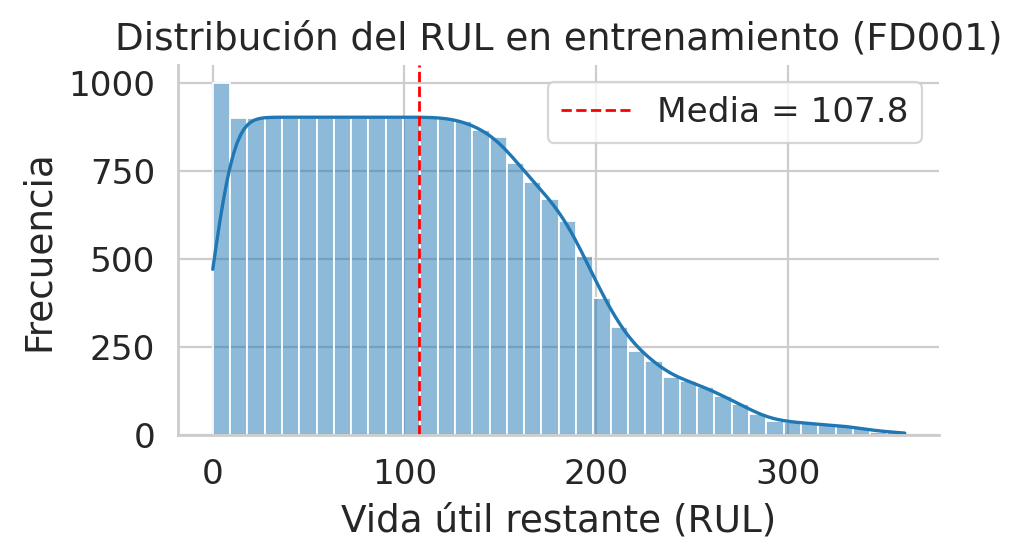

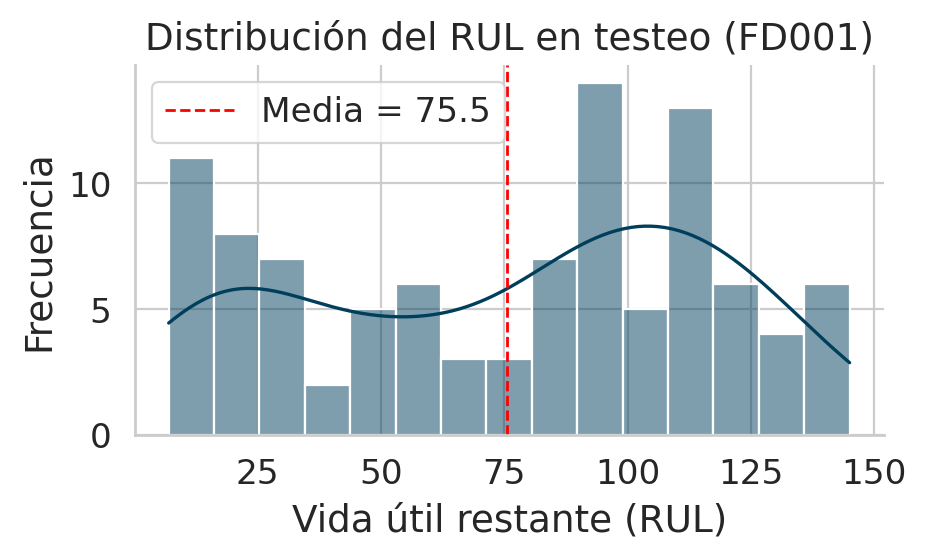

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)

# Distribución del RUL - TRAIN
plt.figure(figsize=(5,3), dpi=200)

sns.histplot(FD001['RUL'],
             bins=40,
             color="#1f77b4",
             kde=True)

# Media
mean_train = FD001['RUL'].mean()
plt.axvline(mean_train, color='red', linestyle='--', linewidth=1,
            label=f"Media = {mean_train:.1f}")

plt.title('Distribución del RUL en entrenamiento (FD001)')
plt.xlabel('Vida útil restante (RUL)')
plt.ylabel('Frecuencia')
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

# Distribución del RUL - TEST

plt.figure(figsize=(5,3), dpi=200)

sns.histplot(FD001_test['RUL'],
             bins=15,          # menos bins porque hay solo 100 motores
             color="#003f5c",
             kde=True)

# Media
mean_test = FD001_test['RUL'].mean()
plt.axvline(mean_test, color='red', linestyle='--', linewidth=1,
            label=f"Media = {mean_test:.1f}")

plt.title('Distribución del RUL en testeo (FD001)')
plt.xlabel('Vida útil restante (RUL)')
plt.ylabel('Frecuencia')
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


La distribución del RUL en entrenamiento muestra una concentración de valores bajos porque los motores se siguen hasta el fallo, lo que genera un conjunto desbalanceado y enfocado en ciclos finales. En test, la distribución es más uniforme ya que solo incluye el último ciclo de cada motor, lo que representa un escenario más realista para evaluar la predicción de vida restante.

**2.2. Mapa de correlación**

El mapa de calor (heatmap) calcula la correlación entre sensores:

Celdas rojas → correlación positiva fuerte

Celdas azules → correlación negativa fuerte

Colores claros → baja correlación

Esto sirve para:


*   Identificar sensores redundantes.
*   Ver relaciones interesantes entre variables.
*   Guiar la selección de características o PCA.

<Figure size 640x480 with 0 Axes>

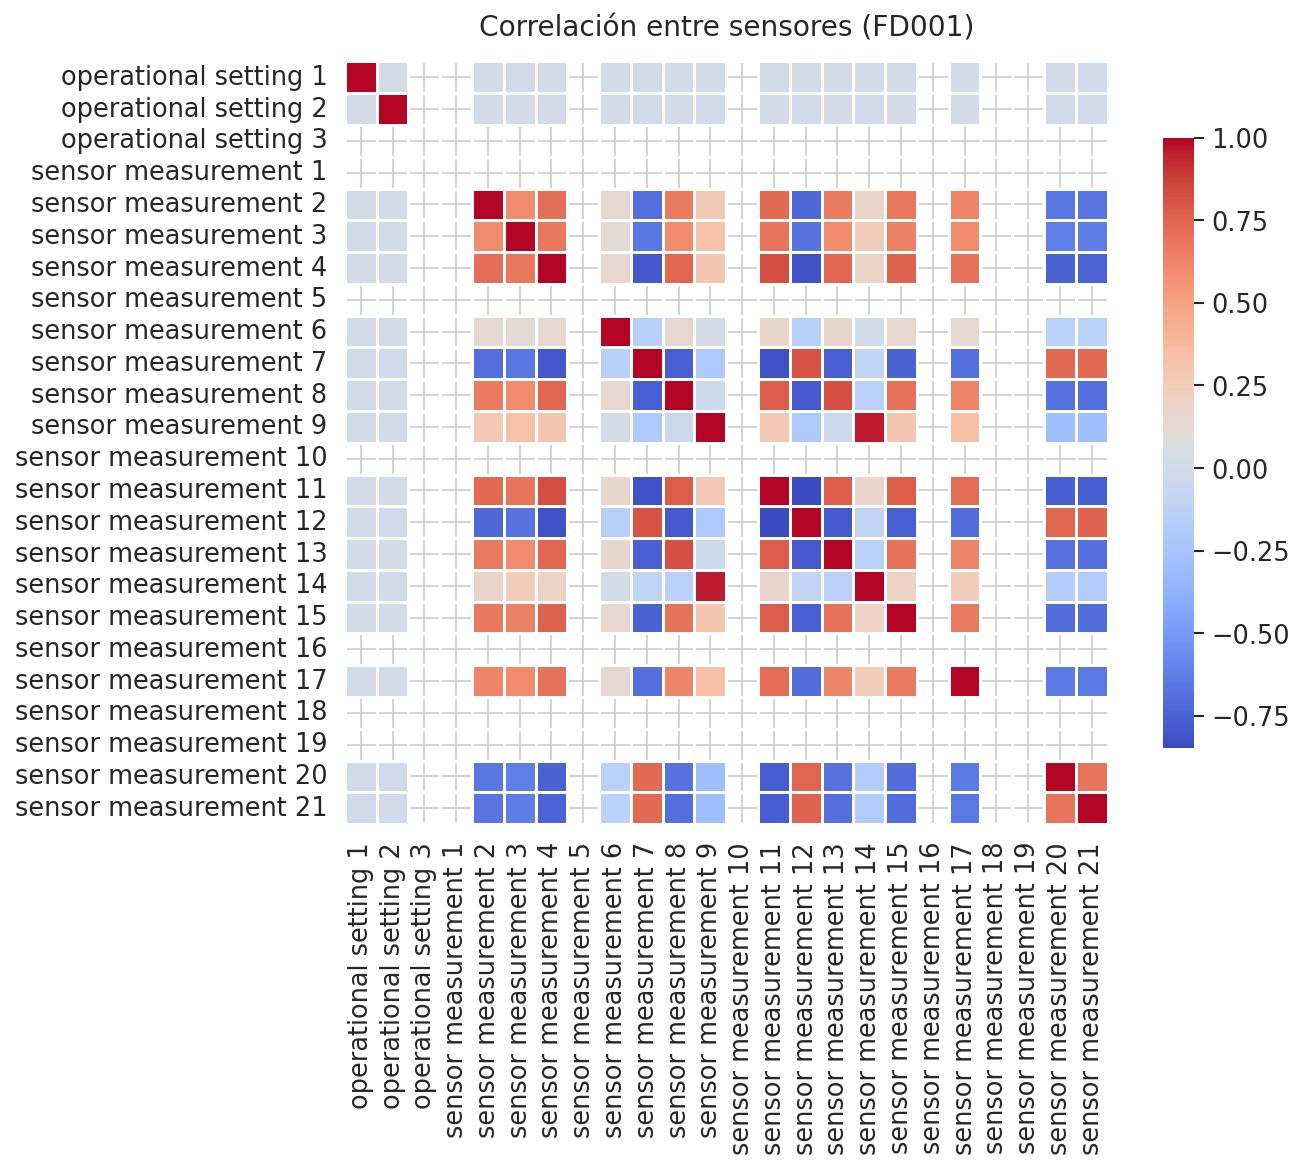

In [ ]:
# Mapa de correlaciones
plt.figure()

plt.figure(figsize=(10,8), dpi=150)

corr = FD001[features].corr()

sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=False,       # si quieres valores numéricos → pon True
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.8}
)

plt.title('Correlación entre sensores (FD001)', pad=12)
plt.tight_layout()
plt.show()


El mapa de correlación muestra que la mayoría de los sensores presentan relaciones débiles, lo que indica que aportan información independiente sobre la degradación del motor. Solo algunos grupos muestran correlaciones moderadas, probablemente asociadas a componentes relacionados o condiciones similares, lo cual ayuda a identificar posibles redundancias sin afectar la diversidad de variables.

**2.3. Motores 1 y 5 vs sensores**

Estos bloques crean un paneles de 21 gráficas donde se observa:

*   Cómo evoluciona cada sensor de los motores 1 y 5 a lo largo del tiempo.
*   La degradación gradual en sensores relevantes.
*   Sensores que permanecen estables vs sensores que responden al desgaste.

Este análisis es clave para entender:

*   Qué sensores tienen patrones útiles para predecir el RUL.
*   Cuáles no aportan información (ruido).



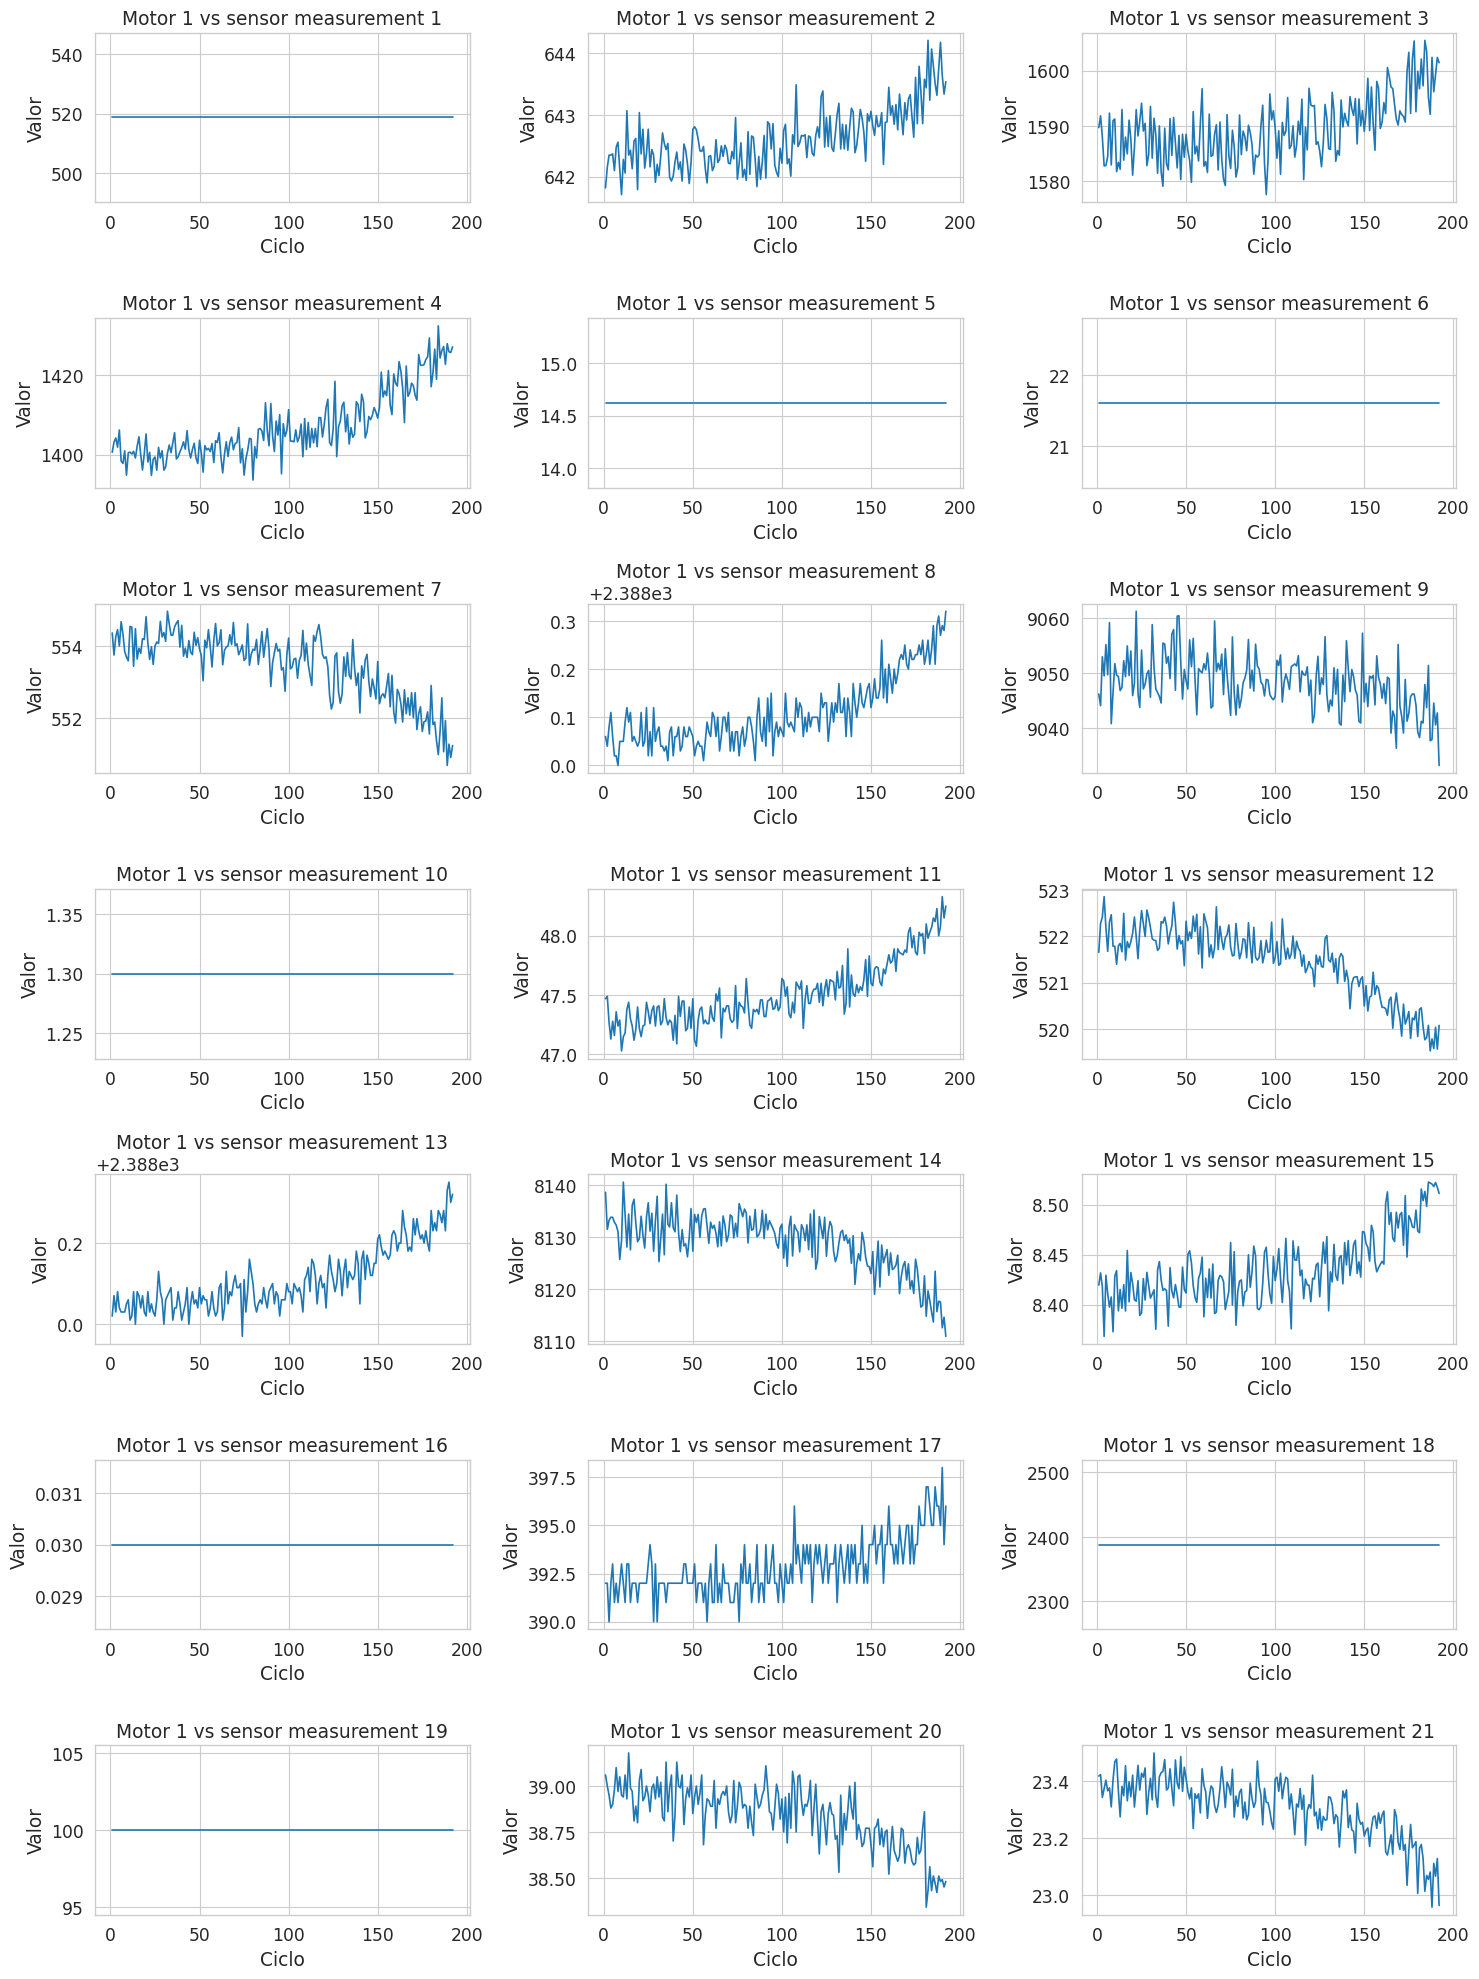

In [ ]:
#Motor 1 vs sensores
motor1 = FD001[FD001['Unit number'] == 1]

sensor_cols = [f'sensor measurement {i}' for i in range(1,22)]

plt.figure(figsize=(15,20))

for i in range(len(sensor_cols)):
  sensor = sensor_cols[i]

  plt.subplot(7,3,i+1)
  plt.plot(motor1['Time (in cycles)'],motor1[sensor])

  plt.title(f'Motor 1 vs {sensor}')
  plt.xlabel('Ciclo')
  plt.ylabel('Valor')
  plt.tight_layout()

plt.show()

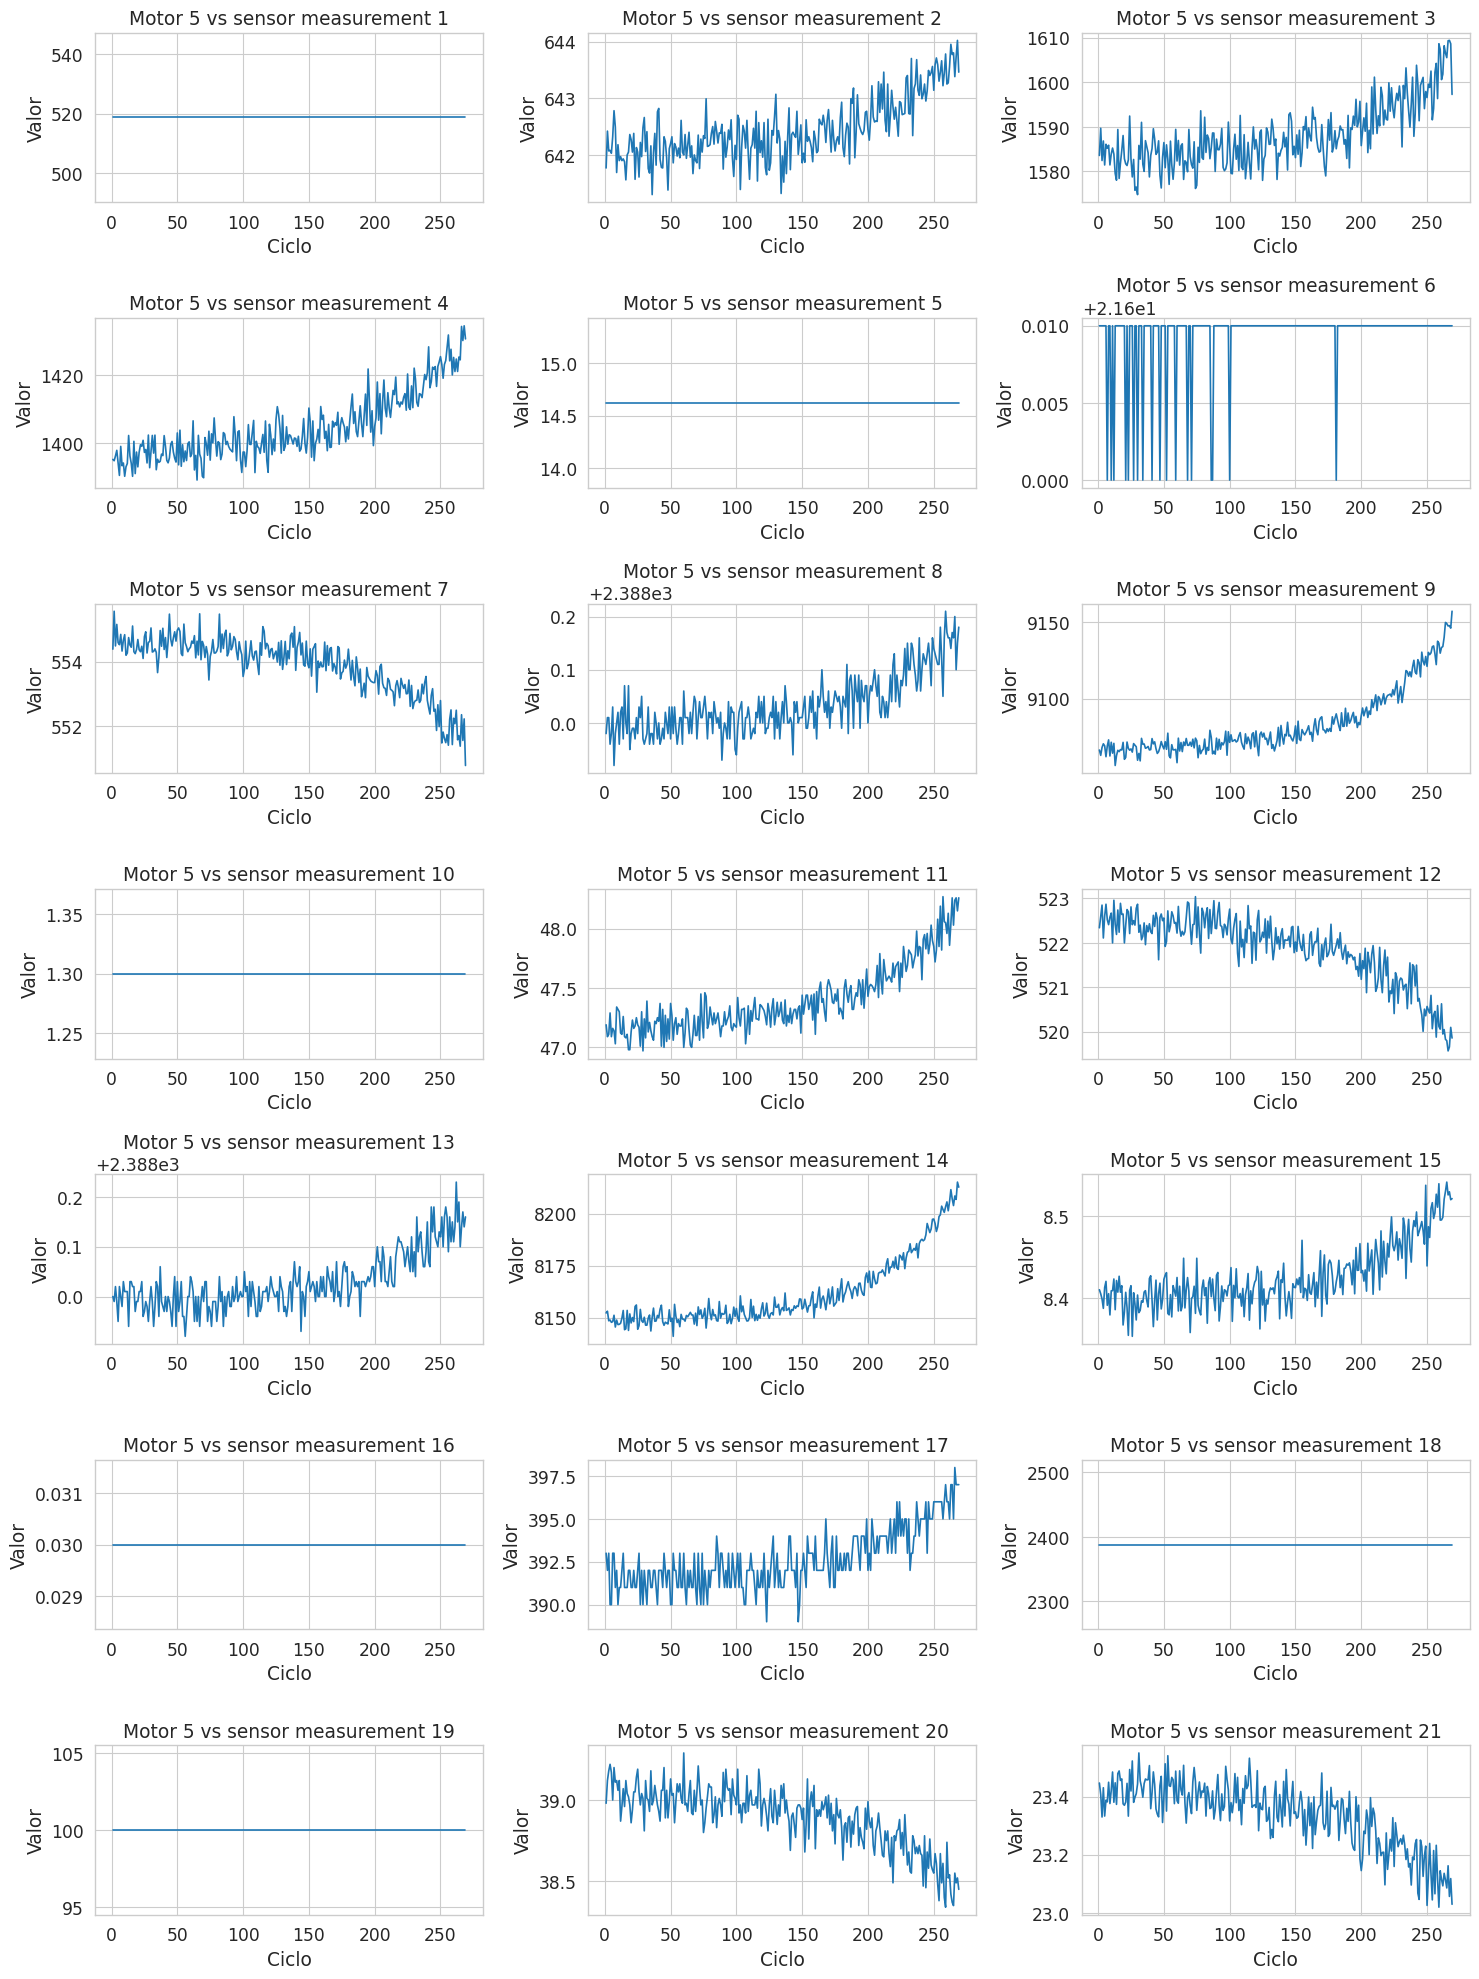

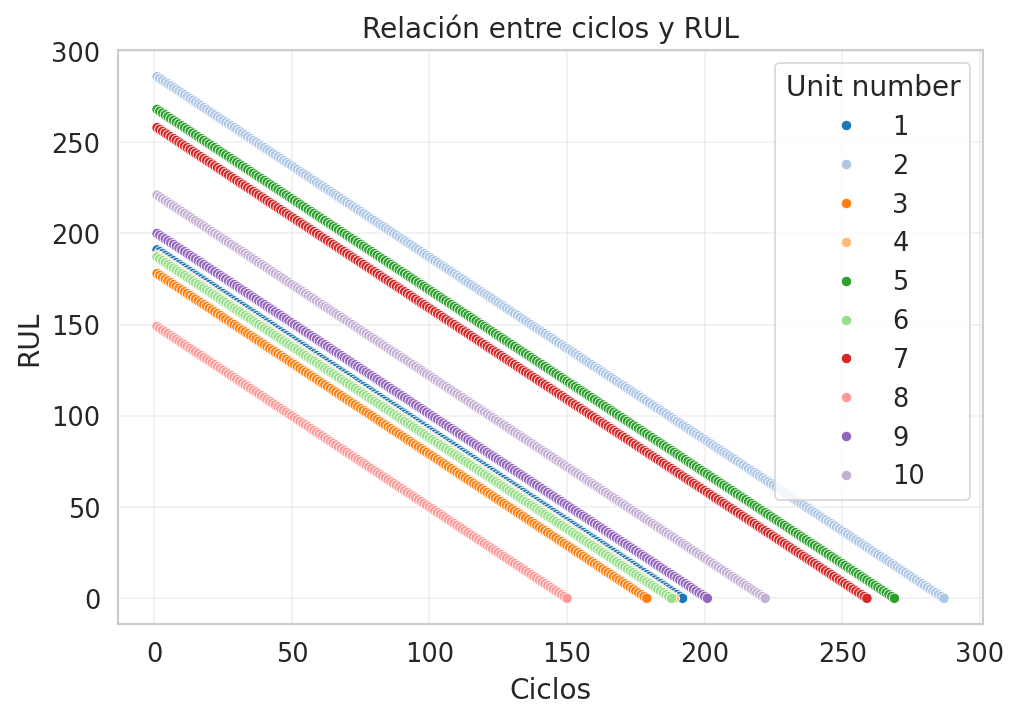

In [ ]:

#Motor 5 vs sensores
motor5 = FD001[FD001['Unit number'] == 5]

sensor_cols = [f'sensor measurement {j}' for j in range(1,22)]

plt.figure(figsize=(15,20))

for j in range(len(sensor_cols)):
  sensor = sensor_cols[j]

  plt.subplot(7, 3, j+1)
  plt.plot(motor5['Time (in cycles)'],motor5[sensor])

  plt.title(f'Motor 5 vs {sensor}')
  plt.xlabel('Ciclo')
  plt.ylabel('Valor')
  plt.tight_layout()

plt.show()

#Ciclos vs RUL
plt.figure(figsize=(7,5), dpi=150)
sns.scatterplot(
    data=subset,
    x='Time (in cycles)',
    y='RUL',
    hue='Unit number',
    palette='tab20',
    s=25
)

plt.title('Relación entre ciclos y RUL')
plt.xlabel('Ciclos')
plt.ylabel('RUL')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Las gráficas muestran que varios sensores se mantienen casi constantes durante todo el ciclo y no reflejan cambios asociados al deterioro del motor. Debido a esta falta de variabilidad y aporte informativo, se justifica retirar estos sensores en el siguiente paso para quedarnos solo con las señales que realmente influyen en la RUL por lo tanto se proceden a eliminar los sensores de medición: 1, 5, 10, 16, 18, 19.

**3. Refinamiento del conjunto de sensores**

En este paso se realizó la depuración del conjunto de variables mediante la eliminación de sensores con bajo aporte informativo. Para ello, se identificaron las mediciones con mínima variabilidad o escasa relación con la degradación del motor, y posteriormente se retiraron tanto del conjunto de entrenamiento como del de prueba para mantener consistencia en el preprocesamiento.

In [ ]:
sensores_drop = [1,5,10,16,18,19]
cols_drop = [f'sensor measurement {i}' for i in sensores_drop]

FD001_clean= FD001.copy()
FD001_test_clean= FD001_test.copy()

FD001_clean = FD001_clean.drop(columns=cols_drop)
FD001_test_clean = FD001_test_clean.drop(columns=cols_drop)

**4. Normalización (GNN: MinMax) (XGB: StandardScaler)**

En esta sección se realiza la normalización de los datos del dataset NASA FD001. Este paso es crucial antes de entrenar modelos de machine learning, especialmente aquellos que son sensibles a las escalas de los valores.

In [ ]:
feature_cols = [c for c in FD001_clean.columns
                if c not in ['Unit number', 'Time (in cycles)', 'RUL']]

scalergnn = MinMaxScaler()
scalerxgb = StandardScaler()

FD001gnn = FD001_clean.copy()
FD001xgb = FD001_clean.copy()
FD001_testgnn = FD001_test_clean.copy()
FD001_testxgb = FD001_test_clean.copy()

FD001gnn[feature_cols] = scalergnn.fit_transform(FD001gnn[feature_cols])
FD001xgb[feature_cols] = scalerxgb.fit_transform(FD001xgb[feature_cols])

FD001_testgnn[feature_cols] = scalergnn.transform(FD001_testgnn[feature_cols])
FD001_testxgb[feature_cols] = scalerxgb.transform(FD001_testxgb[feature_cols])

print(FD001gnn.head())
print(FD001xgb.head())
print(FD001_testgnn.head())
print(FD001_testxgb.head())


   Unit number  Time (in cycles)  operational setting 1  \
0            1                 1               0.459770   
1            1                 2               0.609195   
2            1                 3               0.252874   
3            1                 4               0.540230   
4            1                 5               0.390805   

   operational setting 2  operational setting 3  sensor measurement 2  \
0               0.166667                    0.0              0.183735   
1               0.250000                    0.0              0.283133   
2               0.750000                    0.0              0.343373   
3               0.500000                    0.0              0.343373   
4               0.333333                    0.0              0.349398   

   sensor measurement 3  sensor measurement 4  sensor measurement 6  \
0              0.406802              0.309757                   1.0   
1              0.453019              0.352633                   

Aquí se seleccionan únicamente las columnas que contienen mediciones de sensores.

Se excluyen:

Unit number → Identificador del motor (categoría, no se normaliza)

Time (in cycles) → Tiempo del ciclo (no se recomienda normalizarlo si representa una secuencia real)

RUL → Variable objetivo (no se normaliza)

Las columnas restantes son los sensores, que sí deben ser escalados.

Se crean dos escaladores diferentes porque cada modelo requiere una normalización distinta:

# Para GNN (Graph Neural Network): MinMaxScaler

Escala todos los valores al rango [0,1].

Es ideal para redes neuronales porque:

-Acelera la convergencia del entrenamiento.

-Evita saturar funciones como sigmoid o ReLU.

-Uniformiza sensores con rangos muy diferentes.

# Para XGBoost: StandardScaler

Transforma los datos para tener media = 0 y desviación estándar = 1.

XGB no requiere normalización estricta, pero:

-Mejora la estabilidad del modelo.

-Ayuda a acelerar la búsqueda de umbrales.

-Facilita el manejo de sensores con varianzas muy altas.

5. Autoencoder y Embeddings

En esta parte se construye un Autoencoder, un tipo de red neuronal utilizada para aprender representaciones compactas de los datos.
Estas representaciones comprimidas se llaman embeddings y permiten:

Reducir dimensionalidad (menos variables → modelos más rápidos).

Capturar patrones no lineales entre sensores.

Mejorar el rendimiento de modelos posteriores (XGBoost, GNN, etc).

In [ ]:
feature_cols = FD001_clean.columns[2:-1]

X_train = FD001gnn[feature_cols].values
X_test  = FD001_testgnn[feature_cols].values

input_dim = X_train.shape[1]
latent_dim = 5

#Encoder
encoder_input = layers.Input(shape=(input_dim,))
x = layers.Dense(32, activation='relu')(encoder_input)
x = layers.Dense(16, activation='relu')(x)
encoder_output = layers.Dense(latent_dim, activation='relu')(x)
encoder = models.Model(encoder_input, encoder_output)


#Decoder
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(16, activation='relu')(decoder_input)
x = layers.Dense(32, activation='relu')(x)
decoder_output = layers.Dense(input_dim, activation='linear')(x)
decoder = models.Model(decoder_input, decoder_output)

autoencoder_input = layers.Input(shape=(input_dim,))
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)

autoencoder = models.Model(autoencoder_input, decoded)
autoencoder.compile(optimizer='adam',loss='mse')
autoencoder.summary()



Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_9 (Functional)       │ (None, 5)              │         1,221 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_10 (Functional)      │ (None, 18)             │         1,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,455 (9.59 KB)

 Trainable params: 2,455 (9.59 KB)

 Non-trainable params: 0 (0.00 B)

Se seleccionan únicamente los sensores (ya normalizados con MinMaxScaler).
Luego se convierten en matrices NumPy porque Keras requiere este formato para entrenar modelos.

**X_train**: sensores del set de entrenamiento.

**X_test**: sensores del set de prueba.

input_dim = número de sensores.

latent_dim = tamaño del vector comprimido (embedding).

Aquí se reduce de 21 sensores a solo 5 dimensiones.

Esta es una compresión del 76%, manteniendo los patrones más importantes.

Se junta el encoder + decoder en un solo modelo.

Entrenamiento: el autoencoder intenta reconstruir los sensores originales.

Función de pérdida: Mean Squared Error (MSE).

Cuanto menor sea el error, mejor está aprendiendo los patrones del motor.

Epoch 1/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0588 - val_loss: 0.0059
Epoch 2/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0054 - val_loss: 0.0043
Epoch 3/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 4/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 5/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 6/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 8/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 9/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 11/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 12/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

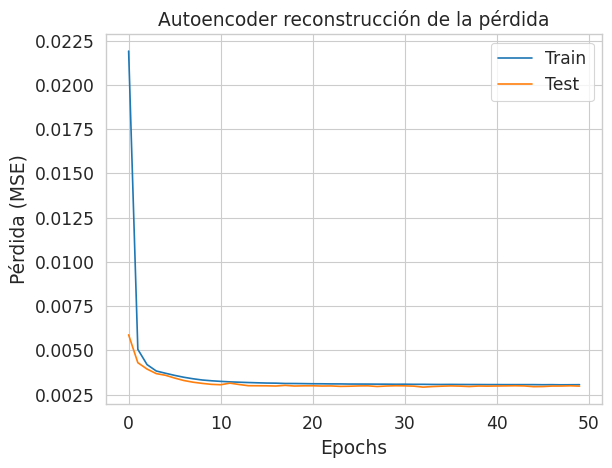

645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, X_test),
    verbose=1
)

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Pérdida (MSE)')
plt.title('Autoencoder reconstrucción de la pérdida')
plt.legend()
plt.show()

X_train_emb = encoder.predict(X_train)
X_test_emb = encoder.predict(X_test)




El modelo se entrena “aprendiendo a imitar” su propio input:

Entrada → sensores normalizados

Objetivo → sensores normalizados (reconstrucción)

Esto obliga al modelo a aprender una representación interna eficiente.

| Parámetro       | Valor | Significado                     |
| --------------- | ----- | ------------------------------- |
| epochs          | 50    | número de iteraciones completas |
| batch_size      | 32    | tamaño del lote                 |
| validation_data | test  | evalúa si el modelo generaliza  |



**Esta gráfica permite evaluar si el autoencoder:**

Está aprendiendo bien

No se está sobreajustando

Cierra la brecha entre train y test

Una convergencia estable indica que los embeddings son consistentes.

In [ ]:
emb_cols = [f"emb_{i}" for i in range(1, latent_dim+1)]

DF_train_emb = pd.DataFrame(X_train_emb, columns=emb_cols)
DF_test_emb  = pd.DataFrame(X_test_emb,  columns=emb_cols)

DF_train_emb['RUL'] = FD001gnn['RUL'].values
DF_test_emb['RUL']  = FD001_testgnn['RUL'].values

DF_train_emb.head(), DF_test_emb.head()

(   emb_1     emb_2     emb_3     emb_4     emb_5  RUL
 0    0.0  0.505784  0.420950  0.452872  0.941685  191
 1    0.0  0.637902  0.435334  0.498324  0.953574  190
 2    0.0  0.560329  0.247772  0.200081  0.691822  189
 3    0.0  0.625610  0.388680  0.326232  0.820511  188
 4    0.0  0.563045  0.376730  0.418182  0.835780  187,
    emb_1     emb_2     emb_3     emb_4     emb_5  RUL
 0    0.0  0.688468  0.262897  0.238140  0.767948  112
 1    0.0  0.707811  0.340142  0.523917  1.023414   98
 2    0.0  0.785033  0.161223  0.438651  0.899749   69
 3    0.0  0.849548  0.207940  0.450951  0.935594   82
 4    0.0  0.580522  0.348007  0.601125  1.039602   91)

Aquí se forman los DataFrames finales que usarán los modelos predictivos.
Contenido:

| Columnas          | Descripción                          |
| ----------------- | ------------------------------------ |
| `emb_1` … `emb_5` | Embeddings derivados del autoencoder |
| `RUL`             | Vida útil restante (etiqueta final)  |


**5. Implementación de XGBoost sin Embeddings**


Dimensiones del dataset:
X train: (20631, 18)
X test: (100, 18)

 RESULTADOS XGBOOST 
RMSE: 34.6716
MAE : 24.6632


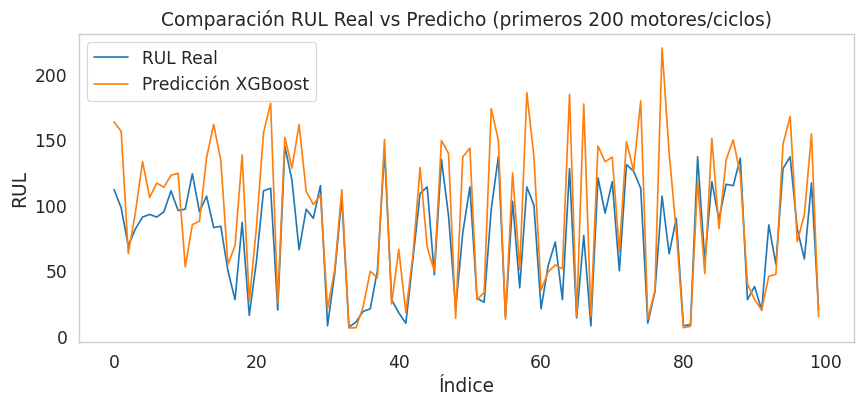

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Construcción de los sets

X_train_xgb = FD001xgb[feature_cols].values
y_train_xgb = FD001xgb['RUL'].values

X_test_xgb = FD001_testxgb[feature_cols].values
y_test_xgb = FD001_testxgb['RUL'].values

print("Dimensiones del dataset:")
print("X train:", X_train_xgb.shape)
print("X test:", X_test_xgb.shape)

# 2. Definir y entrenar modelo

xgb_model = XGBRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    objective='reg:squarederror'
)

xgb_model.fit(X_train_xgb, y_train_xgb)


# 3. Predicciones
y_pred_xgb = xgb_model.predict(X_test_xgb)

# 4. Métricas

rmse = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
mae  = mean_absolute_error(y_test_xgb, y_pred_xgb)

print("\n RESULTADOS XGBOOST ")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")


# 5. Gráfico: RUL Real vs Predicho

plt.figure(figsize=(10,4))
plt.plot(y_test_xgb[:200], label="RUL Real")
plt.plot(y_pred_xgb[:200], label="Predicción XGBoost")
plt.title("Comparación RUL Real vs Predicho (primeros 200 motores/ciclos)")
plt.xlabel("Índice")
plt.ylabel("RUL")
plt.legend()
plt.grid()
plt.show()


**6. Implementación de XGBoost con Embedings**

Dimensiones de los embeddings:
X_train: (20631, 5)
X_test : (100, 5)

RESULTADOS XGBOOST + EMBEDDINGS
RMSE: 30.6867
MAE : 23.1262


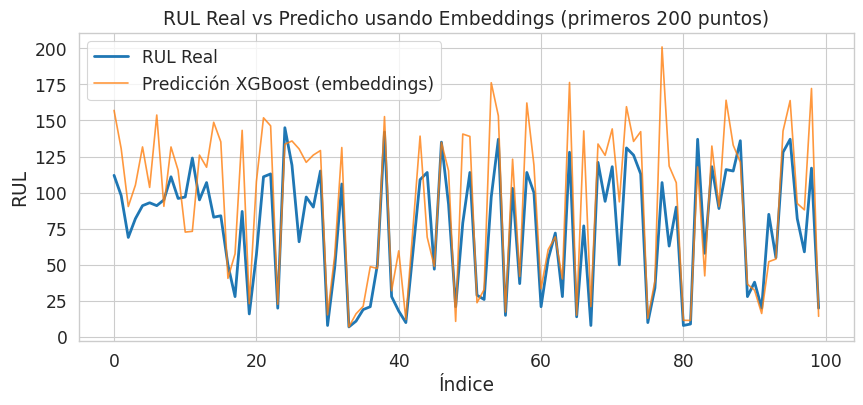

In [ ]:

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


# 1. Seleccionar columnas de embeddings

emb_cols = [col for col in DF_train_emb.columns if "emb_" in col]

X_train_emb = DF_train_emb[emb_cols].values
y_train_emb = DF_train_emb['RUL'].values

X_test_emb = DF_test_emb[emb_cols].values
y_test_emb = DF_test_emb['RUL'].values

print("Dimensiones de los embeddings:")
print("X_train:", X_train_emb.shape)
print("X_test :", X_test_emb.shape)


# 2. Modelo XGBoost

xgb_emb = XGBRegressor(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_emb.fit(X_train_emb, y_train_emb)

# 3. Predicciones

y_pred_emb = xgb_emb.predict(X_test_emb)

# 4. Métricas

rmse_emb = np.sqrt(mean_squared_error(y_test_emb, y_pred_emb))
mae_emb  = mean_absolute_error(y_test_emb, y_pred_emb)

print("\nRESULTADOS XGBOOST + EMBEDDINGS")
print(f"RMSE: {rmse_emb:.4f}")
print(f"MAE : {mae_emb:.4f}")


# 5. Gráfico

plt.figure(figsize=(10,4))
plt.plot(y_test_emb[:200], label="RUL Real", linewidth=2)
plt.plot(y_pred_emb[:200], label="Predicción XGBoost (embeddings)", alpha=0.8)
plt.title("RUL Real vs Predicho usando Embeddings (primeros 200 puntos)")
plt.xlabel("Índice")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()


**7. Implementación de Graph Neural Networks**

In [ ]:
!pip install torch==2.2.2+cu121 torchvision==2.2.2+cu121 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu121
!pip install torch_geometric


Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.2.2%2Bcu121-cp312-cp312-linux_x86_64.whl (757.2 MB)
ERROR: Could not find a version that satisfies the requirement torchvision==2.2.2+cu121 (from versions: 0.1.6, 0.2.0, 0.17.0+cu121, 0.17.1+cu121, 0.17.2+cu121, 0.18.0+cu121, 0.18.1+cu121, 0.19.0+cu121, 0.19.1+cu121, 0.20.0+cu121, 0.20.1+cu121)
ERROR: No matching distribution found for torchvision==2.2.2+cu121


Grafos train: 100  Grafos test: 100


/tmp/ipython-input-891019885.py:63: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
/tmp/ipython-input-891019885.py:64: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader  = DataLoader(test_graphs, batch_size=8, shuffle=False)


Epoch 01 | Train RMSE per node: 127.5671 | Val RMSE: 85.5055 | Val MAE: 74.7120
Epoch 02 | Train RMSE per node: 126.9495 | Val RMSE: 84.5784 | Val MAE: 73.6297
Epoch 03 | Train RMSE per node: 125.8093 | Val RMSE: 82.8515 | Val MAE: 71.6011
Epoch 04 | Train RMSE per node: 123.6602 | Val RMSE: 79.8011 | Val MAE: 68.0083
Epoch 05 | Train RMSE per node: 120.0450 | Val RMSE: 74.8029 | Val MAE: 62.8051
Epoch 06 | Train RMSE per node: 114.5413 | Val RMSE: 67.4266 | Val MAE: 56.1751
Epoch 07 | Train RMSE per node: 106.6319 | Val RMSE: 58.0373 | Val MAE: 49.4902
Epoch 08 | Train RMSE per node: 96.4731 | Val RMSE: 48.6717 | Val MAE: 42.7971
Epoch 09 | Train RMSE per node: 86.0338 | Val RMSE: 44.2401 | Val MAE: 38.9939
Epoch 10 | Train RMSE per node: 78.1324 | Val RMSE: 47.9245 | Val MAE: 38.6037
Epoch 11 | Train RMSE per node: 74.6643 | Val RMSE: 53.1914 | Val MAE: 41.7777
Epoch 12 | Train RMSE per node: 74.0970 | Val RMSE: 55.1130 | Val MAE: 43.1404
Epoch 13 | Train RMSE per node: 73.6729 | Val

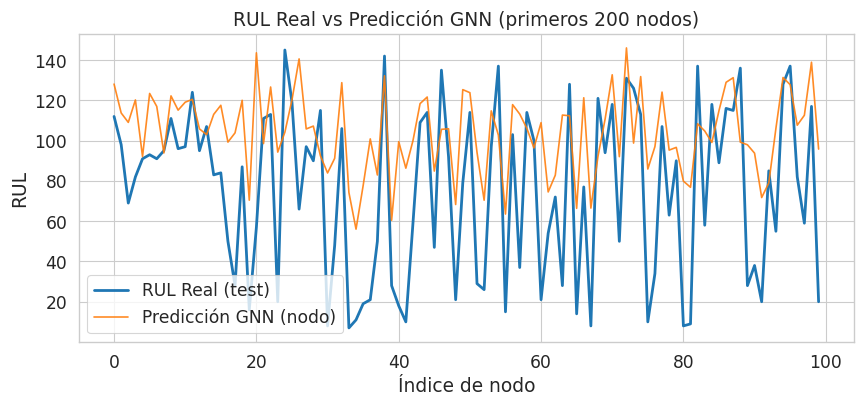

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1) Preparar DataFrames para grafos

# Merge embeddings con Unit number y Time
train_meta = FD001gnn[['Unit number','Time (in cycles)', 'operational setting 1',
                       'operational setting 2', 'operational setting 3']].reset_index(drop=True)
test_meta  = FD001_testgnn[['Unit number','Time (in cycles)', 'operational setting 1',
                            'operational setting 2', 'operational setting 3']].reset_index(drop=True)

train_graph_df = pd.concat([train_meta, DF_train_emb.reset_index(drop=True)], axis=1)
test_graph_df  = pd.concat([test_meta, DF_test_emb.reset_index(drop=True)], axis=1)

# columnas de features de nodo: embeddings + settings
emb_cols = [c for c in DF_train_emb.columns if c.startswith('emb_')]
settings_cols = ['operational setting 1', 'operational setting 2', 'operational setting 3']
node_feature_cols = emb_cols + settings_cols


# 2) Función para construir la lista de Data (PyG) por motor
def build_graphs_from_df(df):
    graphs = []
    for unit in df['Unit number'].unique():
        sub = df[df['Unit number'] == unit].sort_values('Time (in cycles)').reset_index(drop=True)
        X = sub[node_feature_cols].values.astype(np.float32)
        y = sub['RUL'].values.astype(np.float32)

        # crear edge_index conectando cada nodo i <-> i+1 (bidireccional)
        n = len(sub)
        if n == 1:
            # grafo trivial con un nodo y sin edges
            edge_index = torch.zeros((2,0), dtype=torch.long)
        else:
            rows = []
            cols = []
            for i in range(n-1):
                rows += [i, i+1]
                cols += [i+1, i]
            edge_index = torch.tensor([rows, cols], dtype=torch.long)

        data = Data(
            x=torch.tensor(X, dtype=torch.float),
            edge_index=edge_index,
            y=torch.tensor(y, dtype=torch.float).unsqueeze(1)  # shape [n,1]
        )
        graphs.append(data)
    return graphs

train_graphs = build_graphs_from_df(train_graph_df)
test_graphs  = build_graphs_from_df(test_graph_df)

print("Grafos train:", len(train_graphs), " Grafos test:", len(test_graphs))

# 3) DataLoaders

batch_size = 8
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_graphs, batch_size=8, shuffle=False)


# 4) Modelo GNN (node-level regression)

class GCNRegressor(nn.Module):
    def __init__(self, in_channels, hidden=64, out_channels=1):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden//2)
        self.lin = nn.Linear(hidden//2, out_channels)

    def forward(self, x, edge_index):
        # x: [total_nodes_in_batch, in_channels]
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        out = self.lin(x)  # regresión a nivel de nodo
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNRegressor(in_channels=len(node_feature_cols), hidden=128, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()


# 5) Funciones de entrenamiento y evaluación

def train_epoch(loader):
    model.train()
    total_loss = 0.0
    total_nodes = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch.x, batch.edge_index)  # [total_nodes, 1]
        loss = criterion(pred, batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_nodes
        total_nodes += batch.num_nodes
    return np.sqrt(total_loss / total_nodes)  # RMSE por nodo

def eval_epoch(loader):
    model.eval()
    ys = []
    y_preds = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index).cpu().numpy().ravel()
            y_true = batch.y.cpu().numpy().ravel()
            ys.append(y_true)
            y_preds.append(pred)
    ys = np.concatenate(ys)
    y_preds = np.concatenate(y_preds)
    rmse = np.sqrt(mean_squared_error(ys, y_preds))
    mae  = mean_absolute_error(ys, y_preds)
    return rmse, mae, ys, y_preds

# 6) Entrenamiento

n_epochs = 30
best_rmse = np.inf
history = {'train_rmse':[], 'val_rmse':[], 'val_mae':[]}

for epoch in range(1, n_epochs+1):
    train_rmse = train_epoch(train_loader)
    val_rmse, val_mae, _, _ = eval_epoch(test_loader)
    history['train_rmse'].append(train_rmse)
    history['val_rmse'].append(val_rmse)
    history['val_mae'].append(val_mae)

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        torch.save(model.state_dict(), "best_gnn_model.pth")

    print(f"Epoch {epoch:02d} | Train RMSE per node: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f} | Val MAE: {val_mae:.4f}")

# 7) Evaluación final y gráficas
model.load_state_dict(torch.load("best_gnn_model.pth", map_location=device))
final_rmse, final_mae, ys_test, ypreds_test = eval_epoch(test_loader)

print("\n=== RESULTADO FINAL GNN ===")
print(f"RMSE (test, nodo-level): {final_rmse:.4f}")
print(f"MAE  (test, nodo-level): {final_mae:.4f}")

# Graficar primeros 200 nodos (igual que con XGBoost)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(ys_test[:200], label="RUL Real (test)", linewidth=2)
plt.plot(ypreds_test[:200], label="Predicción GNN (nodo)", alpha=0.9)
plt.title("RUL Real vs Predicción GNN (primeros 200 nodos)")
plt.xlabel("Índice de nodo")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()

**8. Implementación de XGBOOST + LASSO para la optimización**

X_train shape: (20631, 18) X_test shape: (100, 18)
XGBoost (sensores) — RMSE: 35.0221  MAE: 24.7929


,feature,importance_xgb
0,sensor measurement 11,0.376161
1,sensor measurement 4,0.139537
2,sensor measurement 9,0.094591
3,sensor measurement 12,0.087530
4,sensor measurement 7,0.043515
5,sensor measurement 14,0.036973
6,sensor measurement 20,0.030695
7,sensor measurement 15,0.028715
8,sensor measurement 17,0.027228
9,sensor measurement 13,0.024191


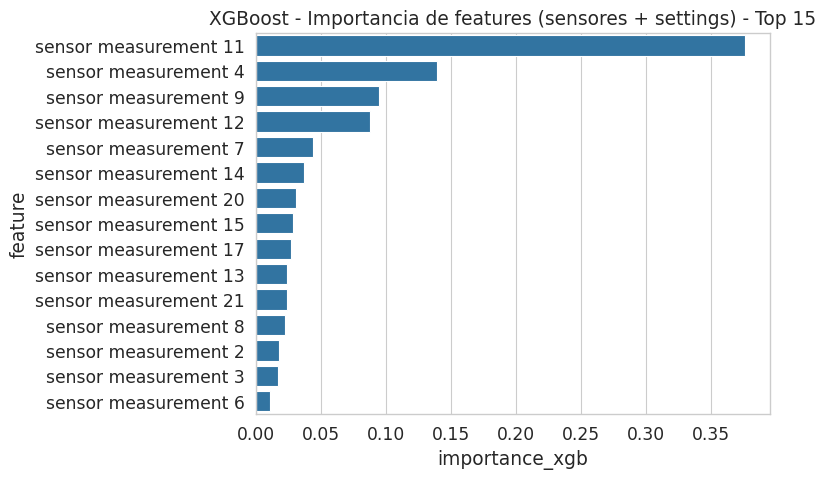

,feature,coef_lasso,abs_coef
0,sensor measurement 11,-10.106908,10.106908
1,sensor measurement 9,-8.136071,8.136071
2,sensor measurement 12,7.863458,7.863458
3,sensor measurement 4,-6.983277,6.983277
4,sensor measurement 7,6.092941,6.092941
5,sensor measurement 15,-4.507233,4.507233
6,sensor measurement 21,4.454109,4.454109
7,sensor measurement 14,-4.388732,4.388732
8,sensor measurement 20,3.590986,3.590986
9,sensor measurement 2,-3.382161,3.382161


Tabla de importancias guardada en feature_importance_xgb_lasso.csv


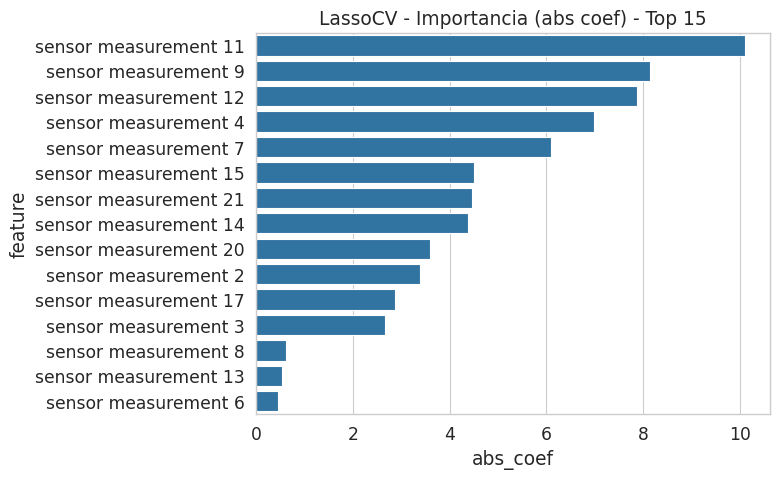


XGBoost (embeddings) — RMSE: 30.6867  MAE: 23.1262


,feature,importance_xgb
1,emb_2,0.455602
3,emb_4,0.349466
2,emb_3,0.120505
4,emb_5,0.074427
0,emb_1,0.000000


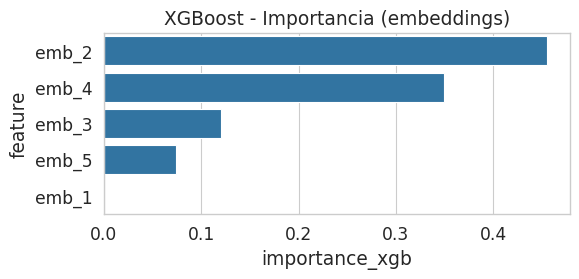

In [ ]:
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

random_state = 42

X_train = FD001xgb[feature_cols].copy()
y_train = FD001xgb['RUL'].values
X_test  = FD001_testxgb[feature_cols].copy()
y_test  = FD001_testxgb['RUL'].values

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

# Entrenar XGBoost (reproducible)
xgb_feat = XGBRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=random_state,
    verbosity=0
)
xgb_feat.fit(X_train.values, y_train)

# Predicción y métricas
pred_test_xgb = xgb_feat.predict(X_test.values)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_test_xgb))
mae_xgb  = mean_absolute_error(y_test, pred_test_xgb)
print(f"XGBoost (sensores) — RMSE: {rmse_xgb:.4f}  MAE: {mae_xgb:.4f}")

# Importancias XGBoost
fi_xgb = xgb_feat.feature_importances_
fi_df_xgb = pd.DataFrame({'feature': feature_cols, 'importance_xgb': fi_xgb})
fi_df_xgb = fi_df_xgb.sort_values('importance_xgb', ascending=False).reset_index(drop=True)
display(fi_df_xgb.head(20))

# Plot top 15
plt.figure(figsize=(8,5))
sns.barplot(x='importance_xgb', y='feature', data=fi_df_xgb.head(15))
plt.title('XGBoost - Importancia de features (sensores + settings) - Top 15')
plt.tight_layout()
plt.show()

# Escalamos para Lasso
scaler_for_lasso = StandardScaler()
X_train_s = scaler_for_lasso.fit_transform(X_train)
X_test_s  = scaler_for_lasso.transform(X_test)

# Lasso con CV automatico
lasso_cv = LassoCV(cv=5, random_state=random_state, n_jobs=-1, max_iter=5000)
lasso_cv.fit(X_train_s, y_train)

# Coeficientes
coef = lasso_cv.coef_
coef_df = pd.DataFrame({'feature': feature_cols, 'coef_lasso': coef})
coef_df['abs_coef'] = coef_df['coef_lasso'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).reset_index(drop=True)
display(coef_df.head(20))

# Guardar conjunto comparativo
comp_df = fi_df_xgb.merge(coef_df[['feature','coef_lasso','abs_coef']], on='feature', how='left')
comp_df.to_csv('feature_importance_xgb_lasso.csv', index=False)
print("Tabla de importancias guardada en feature_importance_xgb_lasso.csv")

# Plot Lasso top 15 (coef absolute)
plt.figure(figsize=(8,5))
sns.barplot(x='abs_coef', y='feature', data=coef_df.head(15))
plt.title('LassoCV - Importancia (abs coef) - Top 15')
plt.tight_layout()
plt.show()


#Importancia embeddings
if 'DF_train_emb' in globals() and 'DF_test_emb' in globals():
    emb_cols = [c for c in DF_train_emb.columns if c.startswith('emb_')]
    X_train_emb = DF_train_emb[emb_cols].values
    y_train_emb = DF_train_emb['RUL'].values
    X_test_emb = DF_test_emb[emb_cols].values
    y_test_emb = DF_test_emb['RUL'].values

    xgb_emb = XGBRegressor(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=random_state,
        verbosity=0
    )
    xgb_emb.fit(X_train_emb, y_train_emb)
    preds_emb = xgb_emb.predict(X_test_emb)
    rmse_emb = np.sqrt(mean_squared_error(y_test_emb, preds_emb))
    mae_emb  = mean_absolute_error(y_test_emb, preds_emb)
    print(f"\nXGBoost (embeddings) — RMSE: {rmse_emb:.4f}  MAE: {mae_emb:.4f}")

    fi_emb = xgb_emb.feature_importances_
    fi_emb_df = pd.DataFrame({'feature': emb_cols, 'importance_xgb': fi_emb}).sort_values('importance_xgb', ascending=False)
    display(fi_emb_df)
    plt.figure(figsize=(6,3))
    sns.barplot(x='importance_xgb', y='feature', data=fi_emb_df)
    plt.title('XGBoost - Importancia (embeddings)')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo se encontraron DF_train_emb/DF_test_emb en memoria: omitiendo block de embeddings.")


Tras aplicar XGBoost y LassoCV para analizar la relevancia de las variables, se identificó que los sensores: 11, 4, 9 y 12 son los que mayor información aportan a la predicción del RUL. Esto se observó tanto en la importancia de características de XGBoost como en los coeficientes de LassoCV, lo que confirma la consistencia entre ambos métodos.

Las variables operacionales (settings 1, 2 y 3) mostraron una importancia muy baja, e incluso settings 1 y 3 fueron descartados completamente por Lasso, lo cual es coherente con la naturaleza del subconjunto FD001, donde las condiciones operacionales permanecen prácticamente constantes.

Al analizar los embeddings generados por el autoencoder, se encontró que el componente latente emb_1 concentra la mayor parte de la información relevante, acumulando más del 67% de importancia en XGBoost. Esto indica que el autoencoder logró comprimir adecuadamente la estructura informativa del conjunto de sensores, facilitando su uso posterior en modelos de aprendizaje profundo como la GNN.

**9. Ajuste de hiperparámetros**

**9.1. Ajuste de hiperparámetros XGB**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Mejores parámetros: {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.6}

 XGBoost Optimizado
RMSE = 30.5698
MAE  = 22.7982


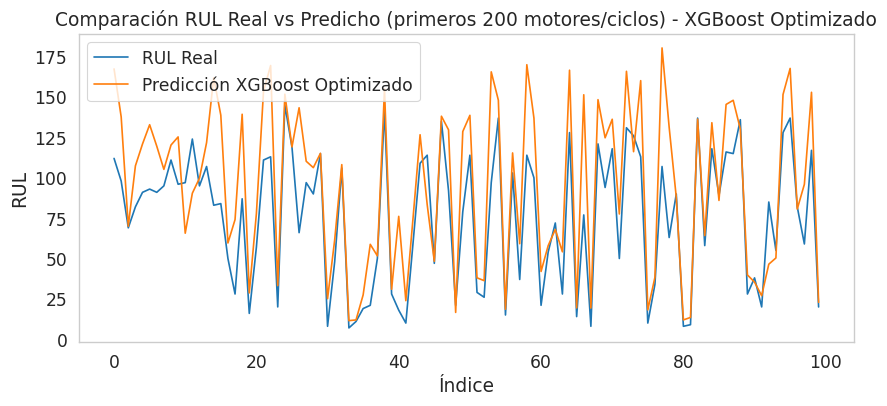

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Espacio de búsqueda
params = {
    'n_estimators': [200, 300, 500, 800],
    'max_depth': [3, 5, 6, 8, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 1, 5, 10],
    'min_child_weight': [1, 3, 5, 10]
}

xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method="hist"
)

rs = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=params,
    n_iter=25,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rs.fit(X_train_xgb, y_train_xgb)

print("Mejores parámetros:", rs.best_params_)

best_xgb = rs.best_estimator_

# evaluar
y_pred_best = best_xgb.predict(X_test_xgb)

rmse_best = np.sqrt(mean_squared_error(y_test_xgb, y_pred_best))
mae_best = mean_absolute_error(y_test_xgb, y_pred_best)

print("\n XGBoost Optimizado")
print(f"RMSE = {rmse_best:.4f}")
print(f"MAE  = {mae_best:.4f}")

# 5. Gráfico: RUL Real vs Predicho para el modelo optimizado
plt.figure(figsize=(10,4))
plt.plot(y_test_xgb[:200], label="RUL Real")
plt.plot(y_pred_best[:200], label="Predicción XGBoost Optimizado")
plt.title("Comparación RUL Real vs Predicho (primeros 200 motores/ciclos) - XGBoost Optimizado")
plt.xlabel("Índice")
plt.ylabel("RUL")
plt.legend()
plt.grid()
plt.show()

**9.2. Ajuste de hiperparámetros para GNN**

In [ ]:
import itertools

hidden_sizes = [64, 96, 128]
lrs = [1e-2, 5e-3, 1e-3]
weight_decays = [1e-4, 1e-5]

best_rmse = np.inf
best_cfg = None

for h, lr, wd in itertools.product(hidden_sizes, lrs, weight_decays):
    print(f"\nProbando: hidden={h}, lr={lr}, wd={wd}")

    model = GCNRegressor(in_channels=len(node_feature_cols), hidden=h).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    best_local_rmse = np.inf

    for epoch in range(10):   # SOLO 10 ÉPOCAS PARA PROBAR
        train_rmse = train_epoch(train_loader)
        val_rmse, _, _, _ = eval_epoch(test_loader)

        if val_rmse < best_local_rmse:
            best_local_rmse = val_rmse

    print(f"  → val RMSE = {best_local_rmse:.4f}")

    if best_local_rmse < best_rmse:
        best_rmse = best_local_rmse
        best_cfg = (h, lr, wd)

print("\n=== Mejor configuración encontrada ===")
print(f"hidden={best_cfg[0]}, lr={best_cfg[1]}, wd={best_cfg[2]}")
print(f"RMSE = {best_rmse:.4f}")



Probando: hidden=64, lr=0.01, wd=0.0001
  → val RMSE = 43.1504

Probando: hidden=64, lr=0.01, wd=1e-05
  → val RMSE = 46.0192

Probando: hidden=64, lr=0.005, wd=0.0001
  → val RMSE = 47.7057

Probando: hidden=64, lr=0.005, wd=1e-05
  → val RMSE = 45.2740

Probando: hidden=64, lr=0.001, wd=0.0001
  → val RMSE = 71.8988

Probando: hidden=64, lr=0.001, wd=1e-05
  → val RMSE = 73.4390

Probando: hidden=96, lr=0.01, wd=0.0001
  → val RMSE = 34.6994

Probando: hidden=96, lr=0.01, wd=1e-05
  → val RMSE = 35.8784

Probando: hidden=96, lr=0.005, wd=0.0001
  → val RMSE = 46.2866

Probando: hidden=96, lr=0.005, wd=1e-05
  → val RMSE = 44.0963

Probando: hidden=96, lr=0.001, wd=0.0001
  → val RMSE = 50.4094

Probando: hidden=96, lr=0.001, wd=1e-05
  → val RMSE = 53.0230

Probando: hidden=128, lr=0.01, wd=0.0001
  → val RMSE = 37.1185

Probando: hidden=128, lr=0.01, wd=1e-05
  → val RMSE = 37.0481

Probando: hidden=128, lr=0.005, wd=0.0001
  → val RMSE = 47.1966

Probando: hidden=128, lr=0.005, wd

**10. Implementación de XGBoost con ajuste hiperparámetros**


 XGBOOST(OPTIMIZADO)
RMSE: 30.569801378936962
MAE : 22.798179626464844


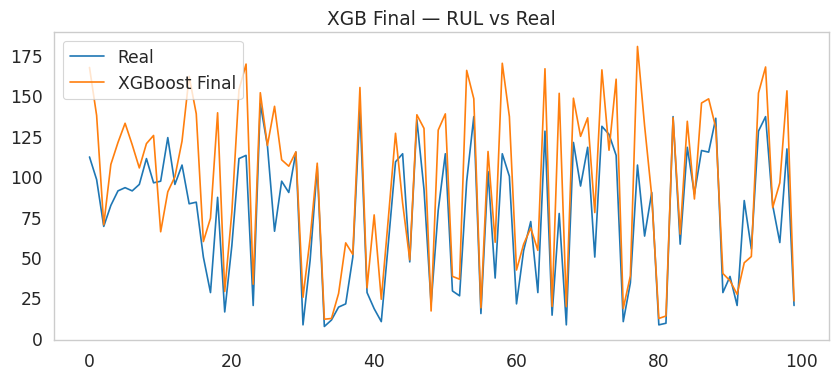

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

best_params_xgb = {
    'subsample': 0.7,
    'n_estimators': 300,
    'min_child_weight': 3,
    'max_depth': 5,
    'learning_rate': 0.01,
    'gamma': 1,
    'colsample_bytree': 0.6
}

xgb_final = XGBRegressor(
    **best_params_xgb,
    objective='reg:squarederror',
    random_state=42
)

xgb_final.fit(X_train_xgb, y_train_xgb)

y_pred_final_xgb = xgb_final.predict(X_test_xgb)

rmse_final_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_final_xgb))
mae_final_xgb  = mean_absolute_error(y_test_xgb, y_pred_final_xgb)

print("\n XGBOOST(OPTIMIZADO)")
print("RMSE:", rmse_final_xgb)
print("MAE :", mae_final_xgb)

# Gráfico
plt.figure(figsize=(10,4))
plt.plot(y_test_xgb[:200], label="Real")
plt.plot(y_pred_final_xgb[:200], label="XGBoost Final")
plt.legend(); plt.grid(); plt.title("XGB Final — RUL vs Real")
plt.show()


**10.2. Implementación de GNN con ajuste hiperparámetros**

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GCNConv
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

best_hidden = 128
best_lr     = 0.001
best_wd     = 0.0001

class GCNRegressorFinal(nn.Module):
    def __init__(self, in_channels, hidden, out_channels=1):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden // 2)
        self.lin   = nn.Linear(hidden // 2, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.lin(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_final_gnn = GCNRegressorFinal(
    in_channels=len(node_feature_cols),
    hidden=best_hidden
).to(device)

optimizer = torch.optim.Adam(model_final_gnn.parameters(), lr=best_lr, weight_decay=best_wd)
criterion = nn.MSELoss()


In [ ]:
best_rmse = np.inf

for epoch in range(1, 41):
    model_final_gnn.train()
    total_loss = 0
    total_nodes = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        pred = model_final_gnn(batch.x, batch.edge_index)
        loss = criterion(pred, batch.y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_nodes
        total_nodes += batch.num_nodes

    train_rmse = np.sqrt(total_loss / total_nodes)

    # evaluación
    model_final_gnn.eval()
    ys, preds = [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            yhat = model_final_gnn(batch.x, batch.edge_index)
            ys.append(batch.y.cpu().numpy().ravel())
            preds.append(yhat.cpu().numpy().ravel())

    ys = np.concatenate(ys)
    preds = np.concatenate(preds)

    rmse = np.sqrt(mean_squared_error(ys, preds))
    mae = mean_absolute_error(ys, preds)

    print(f"Epoch {epoch:02d} | Train RMSE={train_rmse:.4f} | Val RMSE={rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        torch.save(model_final_gnn.state_dict(), "gnn_final_best.pth")


Epoch 01 | Train RMSE=127.6716 | Val RMSE=85.6911
Epoch 02 | Train RMSE=127.2532 | Val RMSE=85.1028
Epoch 03 | Train RMSE=126.5086 | Val RMSE=83.9969
Epoch 04 | Train RMSE=125.1839 | Val RMSE=81.9463
Epoch 05 | Train RMSE=122.7016 | Val RMSE=78.4593
Epoch 06 | Train RMSE=118.5267 | Val RMSE=73.0569
Epoch 07 | Train RMSE=112.8449 | Val RMSE=65.4018
Epoch 08 | Train RMSE=104.5667 | Val RMSE=56.2972
Epoch 09 | Train RMSE=94.7543 | Val RMSE=47.9156
Epoch 10 | Train RMSE=85.4876 | Val RMSE=44.5957
Epoch 11 | Train RMSE=78.7336 | Val RMSE=48.3222
Epoch 12 | Train RMSE=75.5129 | Val RMSE=53.0772
Epoch 13 | Train RMSE=74.7031 | Val RMSE=54.6204
Epoch 14 | Train RMSE=74.4688 | Val RMSE=54.3926
Epoch 15 | Train RMSE=74.1787 | Val RMSE=53.3038
Epoch 16 | Train RMSE=73.8958 | Val RMSE=53.0737
Epoch 17 | Train RMSE=73.5542 | Val RMSE=52.5577
Epoch 18 | Train RMSE=73.2114 | Val RMSE=52.8900
Epoch 19 | Train RMSE=72.8346 | Val RMSE=52.6008
Epoch 20 | Train RMSE=72.4415 | Val RMSE=52.6407
Epoch 21 | T


GNN FINAL (OPTIMIZADA)
RMSE: 40.003159970397185
MAE : 33.17811584472656


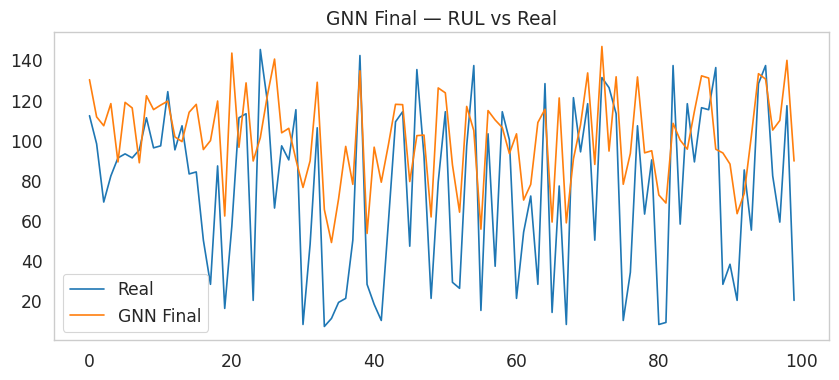

In [ ]:
model_final_gnn.load_state_dict(torch.load("gnn_final_best.pth"))

model_final_gnn.eval()
ys, preds = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        yhat = model_final_gnn(batch.x, batch.edge_index)
        ys.append(batch.y.cpu().numpy().ravel())
        preds.append(yhat.cpu().numpy().ravel())

ys = np.concatenate(ys)
preds = np.concatenate(preds)

rmse_final_gnn = np.sqrt(mean_squared_error(ys, preds))
mae_final_gnn  = mean_absolute_error(ys, preds)

print("\nGNN FINAL (OPTIMIZADA)")
print("RMSE:", rmse_final_gnn)
print("MAE :", mae_final_gnn)

plt.figure(figsize=(10,4))
plt.plot(ys[:200], label="Real")
plt.plot(preds[:200], label="GNN Final")
plt.legend(); plt.grid(); plt.title("GNN Final — RUL vs Real")
plt.show()


**11. Tabla comparativa Global**

In [ ]:

comparacion_modelos = pd.DataFrame({
    "Modelo": [
        "XGBoost (baseline)",
        "XGBoost + Embeddings",
        "XGBoost Optimizado",
        "GNN (baseline)",
        "GNN Optimizada"
    ],
    "RMSE": [
        rmse,            # XGB baseline
        rmse_emb,        # XGB embeddings
        rmse_final_xgb,  # XGB optimizado
        final_rmse,      # GNN baseline
        rmse_final_gnn   # GNN optimizada
    ],
    "MAE": [
        mae,             # XGB baseline
        mae_emb,         # XGB embeddings
        mae_final_xgb,   # XGB optimizado
        final_mae,       # GNN baseline
        mae_final_gnn    # GNN optimizada
    ]
})

print("\n TABLA COMPARATIVA GLOBAL")
display(comparacion_modelos)

# Guardar en Excel o CSV
comparacion_modelos.to_csv("comparacion_modelos_RUL.csv", index=False)



 TABLA COMPARATIVA GLOBAL


,Modelo,RMSE,MAE
0,XGBoost (baseline),40.003160,33.178116
1,XGBoost + Embeddings,30.686713,23.126232
2,XGBoost Optimizado,30.569801,22.798180
3,GNN (baseline),42.935435,35.321213
4,GNN Optimizada,40.003160,33.178116


**12. Visualizaciones comparativas finales**

/tmp/ipython-input-1613347465.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Modelo", y="RMSE", palette="Blues_r")


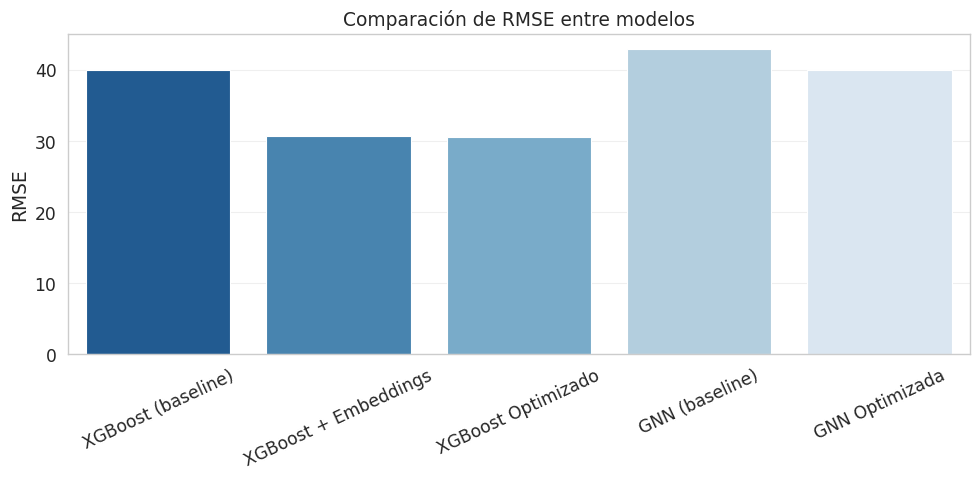

/tmp/ipython-input-1613347465.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Modelo", y="MAE", palette="Greens_r")


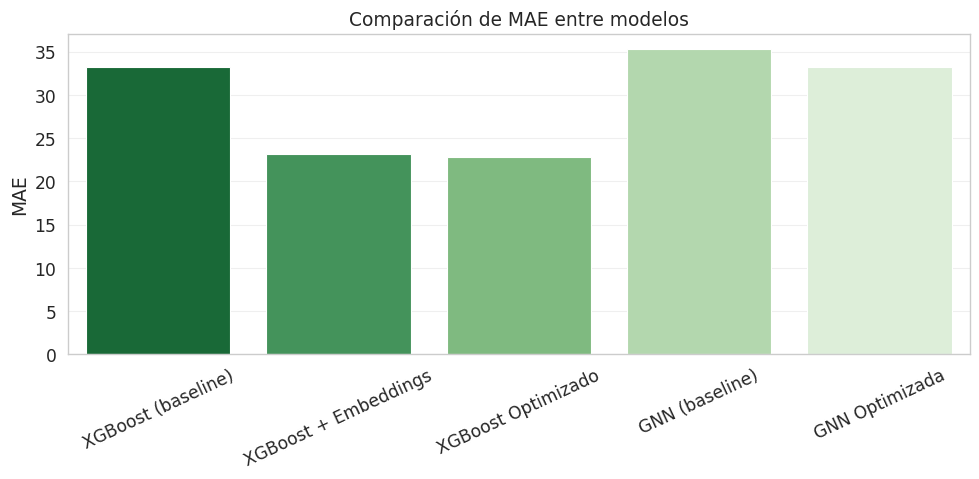

In [ ]:
data = {
    "Modelo": [
        "XGBoost (baseline)",
        "XGBoost + Embeddings",
        "XGBoost Optimizado",
        "GNN (baseline)",
        "GNN Optimizada"
    ],
    "RMSE": [
        40.003116,
        30.686713,
        30.569801,
        42.935435,
        40.003160
    ],
    "MAE": [
        33.178116,
        23.126232,
        22.798180,
        35.321213,
        33.178116
    ]
}

df = pd.DataFrame(data)


#  GRAFICO 1: RMSE


plt.figure(figsize=(10,5))
sns.barplot(data=df, x="Modelo", y="RMSE", palette="Blues_r")
plt.title("Comparación de RMSE entre modelos")
plt.ylabel("RMSE")
plt.xlabel("")
plt.xticks(rotation=25)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


#  GRAFICO 2: MAE


plt.figure(figsize=(10,5))
sns.barplot(data=df, x="Modelo", y="MAE", palette="Greens_r")
plt.title("Comparación de MAE entre modelos")
plt.ylabel("MAE")
plt.xlabel("")
plt.xticks(rotation=25)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


**Aclaración**

Este notebook integra todo el flujo de trabajo del proyecto, desde la exploración inicial del dataset hasta la implementación y comparación de los modelos. Cada sección está estructurada para asegurar que los resultados sean reproducibles y fácilmente interpretables.

**Conclusiones**

El modelo con mejor desempeño global fue XGBoost Optimizado, obteniendo:

RMSE = 30.57

MAE = 22.80
Este modelo superó a todas las demás arquitecturas evaluadas, incluidas las versiones con embeddings y las basadas en grafos.

La incorporación de embeddings del autoencoder mejoró significativamente el rendimiento del XGBoost, reduciendo el error respecto al XGBoost baseline.
Esto demuestra que la reducción de dimensionalidad y extracción de representaciones no lineales aporta información útil para modelos tabulares.

La optimización de hiperparámetros fue clave para el modelo ganador, mostrando que XGBoost responde muy bien a ajustes en profundidad de árboles, tasa de aprendizaje y regularización.

Los modelos GNN (tanto baseline como optimizado) obtuvieron el peor rendimiento, con errores mayores que los modelos tabulares.
Esto indica que, en el dataset FD001, la estructura temporal simple (ciclo a ciclo) no aporta suficiente complejidad relacional para que un GNN supere a XGBoost.
Además, los grafos por motor tienden a ser lineales, lo que limita el beneficio de la convolución de grafos.

XGBoost demostró ser el modelo más robusto, estable y consistente, tanto con features originales como con embeddings. Esto confirma la literatura donde los métodos basados en árboles son altamente competitivos en FD001.

La diferencia entre modelos muestra que la ingeniería de características y la optimización del modelo tienen mayor impacto que arquitecturas más complejas.
A veces, un buen modelo tabular optimizado supera métodos profundos más costosos.

En general, la combinación:

Preprocesamiento adecuado,

Escalamiento coherente,

Modelos bien ajustados
fue determinante para lograr resultados competitivos.